In [ ]:
## Written by Mark A. Rossi for identifying calcium events found in McHenry et al., Nat. Neurosci. 

## input data files are numpy arrays with the form [FOV x ROIs x Frames] called 'extractedsignals.npy'
## NOTE: data should be organized in folders with the form:
#      ~/Experiment/Subject1/extractedsignals.npy  
               # (e.g. extractedsignals.npy is [1 x 38 x 2000] numpy array 1 fov x 38 cells x 2000 frames from mouse1)
#      ~/Experiment/Subject2/extractedsignals.npy
              # (e.g. extractedsignals.npy is [1 x 65 x 2000] numpy array 1 fov x 65 cells x 2000 frames from mouse2)
    
## Event code – What are the output files? ##
    ## event_borders = array of beginning and end of events
    ## dur = all events duration, unfiltered (only z filter)
    ## AUC = all events AUC, unfiltered (only z filter)
    ## Peak_amplitude = all events peak amplitude, unfiltered (only z filter)
    ## Dur_Avg = mean duration per cell, unfiltered (only z filter)
    ## AUC_Avg = mean AUC per cell, unfiltered (only z filter)
    ## Amplitude_Avg = mean peak amplitude per cell, unfiltered 
    ## num_events = number of events per cell, unfiltered 
    ## Peak_amplitude_filt = peak amplitude using the DURATION threshold
    ## amplitude_filt_Avg = mean peak amplitude using the DURATION threshold
    ## Auc_durfilt = AUC values filtered using the DURATION threshold
    ## Auc_durfilt_AVG = mean AUC values filtered using the DURATION threshold
    ## Dur_filt = event durations filtered using the duration filter
    ## Dur_filt_AVG = mean event duration filtered using the duration filter
    ## AUC_filt = event AUCs using the AUC filter
    ## AUC_filt_Avg = mean AUC per cell using AUC filter
    ## Num_events_dur_filt = number of events per cell using the Duration filter
    ## Num_events_AUC_filt = number of events per cell using the AUC filter
    
    ## iei_durfilt = inter-event interval using DURATION filter
    ## iei_durfilt_Avg = mean inter-event interval using Duration filter
    ## inter_event_interval = raw inter event interval
    ## mean_iei = mean inter-event interval, unfiltered
    ## event_frames = frame numbers for events, unfiltered
    ## event_frames_durfilt = frame numbers for events using Duration filter

    ## peak_amp_EvntCT_filt
    ## Amp_EvntCT_filt_AVG.csv
    ## auc_EvntCT_filt
    ## auc_EvntCT_filt_AVG.csv
    ## iei_EvntCT_filt
    ## iei_EvntCT_filt_Avg.csv
    ## dur_EvntCT_filt
    ## dur_EvntCT_filt_Avg.csv'
    ## event_frames_EventCT_filt
    ## event_count_MASK = mask for event count filtered data.  can be used to apply to other sessions with same cells

In [1]:
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from pylab import *
import h5py
import scipy as sc
from scipy import stats
import pandas as pd
%matplotlib inline
import os
import csv

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [28]:
##EDIT THIS SECTION.

## open multiple files called 'extractedsignals.npy' and combine into single array.
## the best way to do this is to point the basedir to a folder. Within that folder there are multiple folders (named to identify
## session,mouse,FOV,etc info), which each contain EXACTLY 1 file called EXACTLY 'extractedsignals.npy'

%cd 'C:\Users\Stuber Lab\Desktop\2p imaging\Experiment'

basedir = 'C:\\Users\\Stuber Lab\\Desktop\\2p imaging\\Experiment'

maxnumneurons = 1000 #just used to initialize arrays. Should be larger than the total number of neurons
maxframes=2000       #number of frames

C:\Users\Stuber Lab\Desktop\2p imaging\Jenna code\160919


In [29]:
#load extracted signals files
signals_pop = np.nan*np.zeros((maxnumneurons,maxframes))
data_dirs = os.walk(basedir).next()[1]
numneuronstillnow = 0
for data_dir in data_dirs:
    signals=np.load(os.path.join(basedir,data_dir,'extractedsignals.npy'))
    numneurons=signals.shape[1]
    numframes=signals.shape[2]
    temp_signals=np.squeeze(signals)
    for a in range(0,numneurons):
        signals_pop[numneuronstillnow+a,:numframes]=temp_signals[a,:]
    numneuronstillnow += numneurons
extractedsignals=signals_pop[:numneuronstillnow,:numframes]

print 'files = '+str(data_dirs)
print '\n Number of neurons = '+str(extractedsignals.shape[0])

files = ['session1', 'session2']

 Number of neurons = 76


In [58]:
## EDIT THIS SECTION ###

filename='test'   #Name to be appended to saved files  as an identifier

## Do you want to use F/Favg or z-scored data?
use_raw_data=['no']  # if 'no' then data will be z-scored
raw_threshold=1.1    # define raw threshold value for identifying events (only used if use_raw_data=['yes'])
z_threshold=1.5      # define z threshold value for identifying events

framerate=5 #framerate in Hz

### Filter the event by duration or area under the curve (values of 0 = unfiltered)
timethreshold=2  #threshold for duration of event (in seconds) 
areathreshold=0  #threshold for area under the curve of event

#do you want to use the low-pass filter to adjust the z-score values?
low_pass_filter_on=['no'] #either 'yes' or 'no'
lowpass_filter=1.1 # Change this to modify the low-pass correction. (values between 1.05 and 1.1 seem to work well)

#do you want to PLOT all individual traces? (if you have a lot of cells, this can be pretty time consuming)
plot_traces=['no'] ##plot unfiltered traces?
plot_traces_filtered=['yes'] ##plot filtered traces?

#do you want to EXPORT individual traces? plot_traces must equal 'yes' in order to export traces.
export_traces=['no']

# do you want to export data files?
export_files=['yes']

## if you want to limit your analysis to a certain range of frames, change start_frame and end_frame below
start_frame=0 
end_frame=2000

## if you want to limit your analysis to a certain range of ROIs, change start_roi and end_roi below
start_roi=0
end_roi=extractedsignals.shape[0]

bin=3 #rolling average smooth; greater values increase the smoothing

## Do you want to filter data by event rate to eliminate cells that have few events or drift?
event_rate_filter_on=['no']
min_event_count=1 #minimum event count to include
max_difference=10 #maximum difference allowed between event rate in first vs. last 1/3 of frames

## Do you want to load and implement a mask from previous data? (must be same cells/order as current data set)
load_mask=['no']
if load_mask[0]=='yes':
    maskfile=np.load('C:\\Users\\Stuber Lab\\Desktop\\2p imaging\\Experiment\\event_count_MASK.npy') #point this to the mask file if you want to use this function

## TIL HERE ##    
    
#save parameters to csv ## Do not edit ##
params=['framerate = '+str(framerate),'z-threshold = '+str(z_threshold),'raw threshold = '+str(raw_threshold),
        'time threshold = '+str(timethreshold),
         'area threshold = '+str(areathreshold),'low pass filter on? = '+low_pass_filter_on[0],
         'low pass filter = '+str(lowpass_filter),'start frame = '+str(start_frame),'end frame = '+str(end_frame),
         'number of cells = '+str(extractedsignals.shape[0]), 'use raw data? = '+str(use_raw_data[0]),
         'Event filter = '+str(event_rate_filter_on[0]),'Min event count = '+str(min_event_count),
         'Max difference = '+str(max_difference),'Load Mask = '+load_mask[0]]
with open(filename+'_parameters','wb') as myfile:
    out=csv.writer(myfile,delimiter=',')
    out.writerow(params)

In [59]:
## for plotting data, change these values
## these do not affect the output files, they are only for visualizing the events in a sample cell

## Edit this section ##
roi_of_interest=16 # pick an ROI of interest
testwindow_start=0 # start frame
testwindow_stop=1000 # End frame

In [60]:
#zscore data
zscore_signals=stats.zscore(extractedsignals[:,:], axis=1)
numrois=zscore_signals.shape[0]
numframes=zscore_signals.shape[1]

if use_raw_data[0]=='yes':
    zscore_signals=extractedsignals
    y_axis='F/F0'
    threshold=raw_threshold
else:
    y_axis='z-scored intensity'
    threshold=z_threshold

print 'Number of ROIs = '+str(numrois)
print 'Number of Frames = '+str(numframes)

Number of ROIs = 76
Number of Frames = 2000


In [61]:
#restrict frames/ROIs to values defined above
zscore_signals=zscore_signals[start_roi:end_roi,start_frame:end_frame]
numrois=zscore_signals.shape[0]
numframes=zscore_signals.shape[1]
print 'Number of ROIs = '+str(numrois)
print 'Number of Frames = '+str(numframes)

Number of ROIs = 76
Number of Frames = 2000


In [62]:
##re-zscore data after removing high-amplitude events

## Correction is as follows:
## 1.    Lowpass filter Raw SIMA traces
## 2.    (Mean(raw) - Mean(filt)) / STD(raw) = Correction Constant
## 3.    Zscore (raw) - Correction Constant = Corrected z-score

zscore_signals_filt=np.nan*np.empty(zscore_signals.shape)
for a in range(0,zscore_signals.shape[0]):
    for b in range(0,zscore_signals.shape[1]):
        if extractedsignals[a,b]>lowpass_filter:
            zscore_signals_filt[a,b]=nan
        else:
            zscore_signals_filt[a,b]=extractedsignals[a,b]
            
zscore_signals_filt_mean=np.nanmean(zscore_signals_filt, axis=1)
zscore_signals_mean=np.nanmean(extractedsignals, axis=1)  
adjust_zscore=zscore_signals_filt_mean-zscore_signals_mean
extractedsignals_std=np.nanstd(extractedsignals, axis=1)
zscore_signals_filt_mean=np.nanmean(zscore_signals_filt, axis=1)
zscore_signals_filt_std=np.nanstd(extractedsignals, axis=1)

for a in range(0,zscore_signals.shape[0]):
    for b in range(0,zscore_signals.shape[1]):
        zscore_signals_filt[a,b]=(zscore_signals_filt[a,b]-zscore_signals_filt_mean[a])/(zscore_signals_filt_std[a])      
for a in range(0,zscore_signals.shape[0]):
    for b in range(0,zscore_signals.shape[1]):
        zscore_signals_filt[a,b]=zscore_signals[a,b]-(adjust_zscore[a]/extractedsignals_std[a])

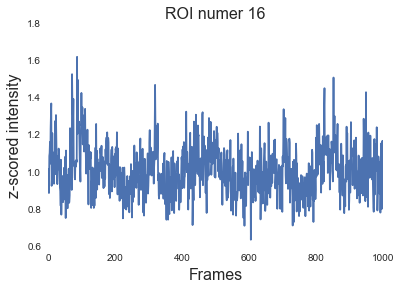

In [63]:
#plot the example cell
fig,ax=plt.subplots(1)
ax.set_axis_bgcolor('white')
sns.tsplot(extractedsignals[roi_of_interest,:])
plt.xlim([testwindow_start, testwindow_stop])
plt.xlabel('Frames', fontsize='16')
plt.ylabel(y_axis, fontsize='16')
plt.title('ROI numer '+str(roi_of_interest), fontsize='16')
plt.show()

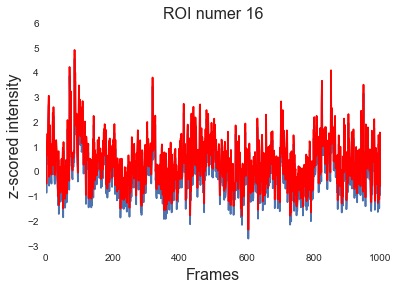

In [64]:
#plot filtered and unfiltered data together to see if traces look good
fig,ax=plt.subplots(1)
ax.set_axis_bgcolor('white')
sns.tsplot(zscore_signals[roi_of_interest,:])
sns.tsplot(zscore_signals_filt[roi_of_interest,:],c='r')
plt.xlim([testwindow_start, testwindow_stop])
plt.xlabel('Frames', fontsize='16')
plt.ylabel(y_axis, fontsize='16')
plt.title('ROI numer '+str(roi_of_interest), fontsize='16')
plt.show()

In [65]:
#do you want to use the low-pass filter to adjust the z-score values? (defined above)
if low_pass_filter_on[0]=='yes':
    zscore_signals=zscore_signals_filt  
else:
    zscore_signals=zscore_signals
print 'low-pass filter = '+low_pass_filter_on[0]

low-pass filter = no


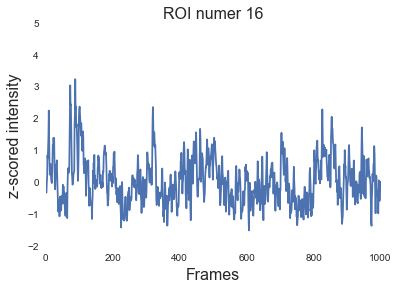

In [66]:
#rolling mean smooth on the zscored data.
#plot some data again to verify that it looks like a smoothed version of the above cell
zscore_signals_df=pd.DataFrame(zscore_signals[:,:])
signals_smoothed=pd.rolling_mean(zscore_signals_df, bin, axis=1)
signals_smoothed=pd.DataFrame.as_matrix(signals_smoothed)
fig,ax=plt.subplots(1)
ax.set_axis_bgcolor('white')
sns.tsplot(signals_smoothed[roi_of_interest,:])
plt.xlim([testwindow_start, testwindow_stop])
plt.xlabel('Frames', fontsize='16')
plt.ylabel(y_axis, fontsize='16')
plt.title('ROI numer '+str(roi_of_interest), fontsize='16')
plt.show()

In [67]:
#### find 'up' and 'down' events.  up corresponds to rising edge
up=np.empty(signals_smoothed.shape)
up[:]=np.NAN
down=np.empty(signals_smoothed.shape)
down[:]=np.NAN
for a in range(0,numrois):
    for i in range(1,numframes-1):
        up[a,i]=signals_smoothed[a,i]>threshold and signals_smoothed[a,i-1]<threshold and signals_smoothed[a,i+1]>threshold
        down[a,i]=signals_smoothed[a,i]>threshold and signals_smoothed[a,i-1]>threshold and signals_smoothed[a,i+1]<threshold

In [68]:
#plot ts with unfiltered event borders overlayed in red and export if desired
if plot_traces[0]=='yes':
    uptimesthreshold=up*threshold
    downtimesthreshold=down*threshold
    uptimesthreshold[uptimesthreshold==0]=np.nan
    downtimesthreshold[downtimesthreshold==0]=np.nan    
    for a in range(0,numrois):
        fig,ax = plt.subplots(1)
        sns.tsplot(signals_smoothed[a,start_frame:end_frame])
        sns.tsplot(downtimesthreshold[a,start_frame:end_frame], c='r', interpolate=False)
        sns.tsplot(uptimesthreshold[a,start_frame:end_frame], c='c', interpolate=False)
        plt.xlabel('Frames', fontsize='16')
        plt.ylabel(y_axis, fontsize='16')
        plt.title('ROI numer '+str(a), fontsize='16')
        ax.set_axis_bgcolor('white')
        plt.show()
        if export_traces[0]=='yes':
            fig.savefig(filename+'_ROI_'+str(a)+'.png', format='png') #uncomment this line to save all traces
            fig.clf()

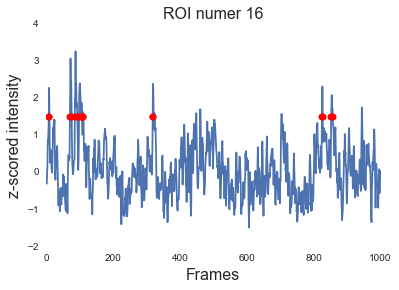

In [69]:
#Remove event if trace starts or ends in 'up' state
#if first nonzero element of combined is -1, then change it to 0, if the last nonzero is 1, make it zero
down=down*-1
combined=up+down #values of 1 indicates rise and -1 indicates fall
for a in range(0,numrois):
    firstup=np.nanargmax(combined[a,:])
    firstdown=np.nanargmin(combined[a,:])
    if firstdown<firstup:
        combined[a,firstdown]=0     
flipped=np.fliplr(combined)
for a in range(0,numrois):
    lastup=np.nanargmax(flipped[a,:])
    lastdown=np.nanargmin(flipped[a,:])
    if lastup<lastdown:
        flipped[a,lastup]=0
combined=np.fliplr(flipped)

#if you have a cell that starts or ends in up state, check that it has been removed by uncommenting the lines below
test=abs(combined)*threshold
test[test==0]=np.nan
fig,ax=plt.subplots(1)
ax.set_axis_bgcolor('white')
sns.tsplot(signals_smoothed[roi_of_interest,testwindow_start:testwindow_stop])
sns.tsplot(test[roi_of_interest,testwindow_start:testwindow_stop], c='r', interpolate=False)
plt.xlabel('Frames', fontsize='16')
plt.ylabel('z-scored intensity', fontsize='16')
plt.title('ROI numer '+str(roi_of_interest), fontsize='16')
plt.show()

In [70]:
## Find events
time=np.arange(numframes)
zscore_signals2=np.squeeze(signals_smoothed)
signals_with_time=np.vstack((zscore_signals2, time)) 
signals_with_time[-1,:]

#find frame number of 'up' and 'down' events.  Up corresponds to rising edge, down=falling edge
diff_down=np.empty(signals_with_time.shape)
diff_down[:]=np.NAN
diff_up=np.empty(signals_with_time.shape)
diff_up[:]=np.NAN

for a in range(0,numrois):
    for i in range(0,numframes):
        if combined[a,i]<0:
            diff_down[a,i]=signals_with_time[-1,i]
        if combined[a,i]>0:
            diff_up[a,i]=signals_with_time[-1,i]
                     
temp_up=np.empty([signals_with_time.shape[1],2])
temp_up[:]=np.NAN
temp_down=np.empty([signals_with_time.shape[1],2])
temp_down[:]=np.NAN
event_time=np.NAN*np.ones(signals_with_time.shape)
allevents=np.NAN*np.ones(signals_with_time.shape)
allareas=np.NAN*np.ones(signals_with_time.shape)
allpeak=np.NAN*np.ones(signals_with_time.shape)

for a in range(0,numrois):
    temp_up[:,0]=diff_up[a,:]
    temp_down[:,1]=diff_down[a,:]
    temp_up2=temp_up[~np.isnan(temp_up)]
    temp_down2 = temp_down[~np.isnan(temp_down)]
    
    event_time=temp_down2-temp_up2
    for q in range (0,event_time.shape[0]):
        area=np.NAN*np.ones(event_time.shape[0])
        placehold_frames=signals_smoothed[a,temp_up2[q]:temp_down2[q]]
        peak=np.max(placehold_frames)
        area=np.trapz(placehold_frames)#, x=None, dx=1)#, axis=-1)   
        allareas[a,q] = area 
        allpeak[a,q] = peak
    allevents[a,:event_time.shape[0]] = event_time
allevents=allevents/framerate
allevents_pre_filt=allevents
allareas_pre_filt=allareas
framethreshold=timethreshold
count_events=~np.isnan(allevents)
count_events=np.sum(count_events,axis=1);count_events=count_events[0:count_events.shape[0]-1]
event_dur_mean=np.nanmean(allevents,axis=1)
auc_mean=np.nanmean(allareas,axis=1)
peak_mean=np.nanmean(allpeak,axis=1)
allareasdurfilt=allareas
allevents_again=allevents
allareas_again=allareas
allpeak_again=allpeak

# ##save data as csv and numpy arrays#
if export_files[0]=='yes':
    # np.savetxt(filename+'_event_borders.csv', combined.T, delimiter=',')
    # np.save(filename+'_event_borders', combined)
    # np.savetxt(filename+'_event_dur.csv', allevents.T, delimiter=',')
    np.save(filename+'_dur', allevents)
    # np.savetxt(filename+'_event_AUC.csv', allareas.T, delimiter=',')
    np.save(filename+'_AUC', allareas)
    # np.savetxt(filename+'_peak_amplitude.csv', allpeak.T, delimiter=',')
    np.save(filename+'_peak_amplitude', allpeak)
    np.savetxt(filename+'_dur_Avg.csv',event_dur_mean,delimiter=',')
    np.savetxt(filename+'_AUC_Avg.csv',auc_mean,delimiter=',')
    np.savetxt(filename+'_amplitude_Avg.csv',peak_mean,delimiter=',')
    np.savetxt(filename+'_num_events.csv',count_events,delimiter=',',fmt='%i')

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [71]:
##find event times and export inter-event intervals
combine_time=np.vstack((up,time))
for a in range(0,numrois):
    for b in range(0,numframes):
        if combined[a,b]==1:
            combine_time[a,b]=combine_time[-1,b]
event_time=np.nan*np.zeros((combined.shape))
event_iei=np.nan*np.zeros((combined.shape))
combine_time[combine_time==0]=np.nan
for a in range(0,numrois):
    temp_time=combine_time[a,:]
    temp_time=temp_time[~isnan(temp_time)]
    temp_iei=np.diff(temp_time)
    event_time[a,0:temp_time.shape[0]]=temp_time
    event_iei[a,0:temp_iei.shape[0]]=temp_iei
event_iei=event_iei/framerate
event_iei_mean=np.nanmean(event_iei,axis=1)
    
if export_files[0]=='yes':
    np.save(filename+'_event_frames',event_time)
    np.savetxt(filename+'event_frames.csv',event_time.T,delimiter=',')
    np.save(filename+'_inter_event_interval',event_iei)
    np.savetxt(filename+'_mean_iei.csv',event_iei_mean,delimiter=',')

In [72]:
#remove nans from event arrays arrays
allevents2=allevents[~np.isnan(allevents)]
allareas2=allareas[~np.isnan(allareas)]
allpeak2=allpeak[~np.isnan(allpeak)]
alliei=event_iei[~np.isnan(event_iei)]

Number of events = 1253


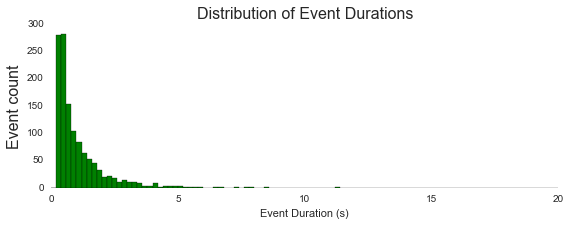

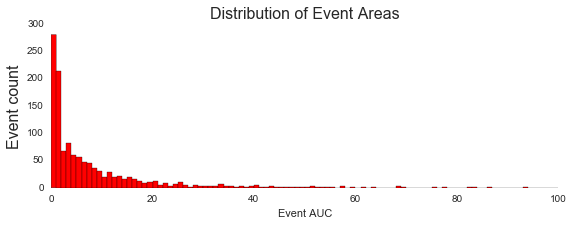

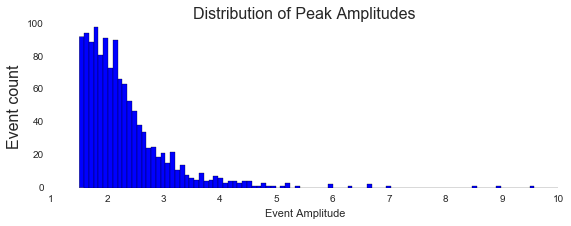

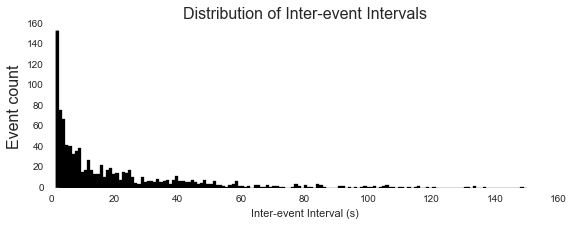

In [73]:
#plot histogram for all AUC, duration of Ca event (in seconds), and peak response amplitude
print 'Number of events = '+str(allareas2.shape[0])

def plot_histogram(data,bins,xmin,xmax,title,xtitle,color):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(322)
    plt.hist(data, bins, [xmin,xmax], facecolor=color)
    plt.title('Distribution of '+title, fontsize='16')
    plt.ylabel('Event count', fontsize='16')
    ax.set_axis_bgcolor('white')
    plt.xlabel(xtitle)
              
fig1=plot_histogram(allevents2,100,0,20,'Event Durations','Event Duration (s)','green')
fig2=plot_histogram(allareas2,100,0,100,'Event Areas','Event AUC','red')
fig3=plot_histogram(allpeak2,100,threshold,10,'Peak Amplitudes','Event Amplitude','blue')
fig4=plot_histogram(alliei,150,threshold,150,'Inter-event Intervals','Inter-event Interval (s)','k')

In [74]:
#filter data based on thresholds defined above
allevents_pre_filt[allevents_pre_filt<framethreshold]=np.nan
allareas_pre_filt[allareas_pre_filt<areathreshold]=np.nan
allevents_filt=allevents_pre_filt[~np.isnan(allevents_pre_filt)]
allareas_filt=allareas_pre_filt[~np.isnan(allareas_pre_filt)]

In [75]:
#filter peak amplitude, auc, and iei using the filtered duration data
peak_filt=allpeak
auc_durfilt=allareasdurfilt
event_frames_durfilt=event_time
iei_durfilt=np.nan*np.zeros((allevents.shape))
event_frames_durfilt=np.vstack((event_frames_durfilt,(np.nan*np.zeros((1,numframes)))))

for a in range(0,allevents.shape[0]):
    for b in range(0,allevents.shape[1]):
        if allevents[a,b]>0:
            peak_filt[a,b]=peak_filt[a,b]
            auc_durfilt[a,b]=auc_durfilt[a,b]
            event_frames_durfilt[a,b]=event_frames_durfilt[a,b]
        else:
            peak_filt[a,b]=np.nan 
            auc_durfilt[a,b]=np.nan
            event_frames_durfilt[a,b]=np.nan
peak_filt_mean=np.nanmean(peak_filt,axis=1)
auc_durfilt_mean=np.nanmean(auc_durfilt,axis=1)

for a in range(0,numrois):
    temp_frame_nums=event_frames_durfilt[a,:]
    temp_frame_nums=temp_frame_nums[~np.isnan(temp_frame_nums)]
    temp_iei=np.diff(temp_frame_nums)
    iei_durfilt[a,0:temp_iei.shape[0]]=temp_iei
iei_durfilt=iei_durfilt/framerate
iei_durfilt_mean=np.nanmean(iei_durfilt,axis=1)

if export_files[0]=='yes':
    np.save(filename+'_peak_amplitude_filt', peak_filt)
    np.savetxt(filename+'_Amplitude_filt_AVG.csv',peak_filt_mean,delimiter=',')
    np.save(filename+'_auc_durfilt', auc_durfilt)
    np.savetxt(filename+'_auc_durfilt_AVG.csv',auc_durfilt_mean,delimiter=',')
    np.save(filename+'_iei_durfilt',iei_durfilt)
    np.savetxt(filename+'_iei_durfilt_Avg.csv',iei_durfilt_mean,delimiter=',')
    np.save(filename+'_event_frames_durfilt',event_frames_durfilt)

Number of events for duration filter = 159
Number of events for area filter = 1253


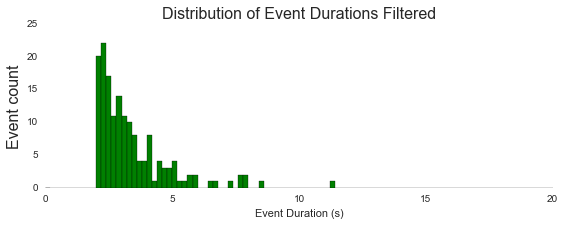

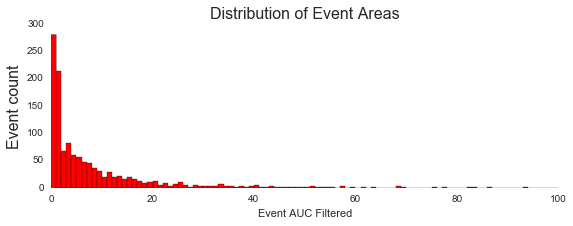

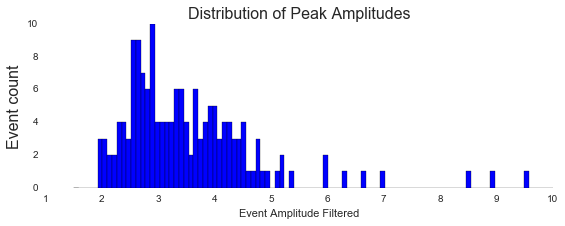

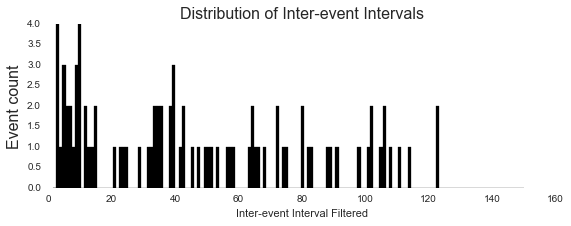

In [76]:
#plot histograms of filterd data
print 'Number of events for duration filter = '+str(allevents_filt.shape[0])
print 'Number of events for area filter = '+str(allareas_filt.shape[0])

fig5=plot_histogram(allevents_filt,100,0,20,'Event Durations Filtered','Event Duration (s)','green')
fig6=plot_histogram(allareas_filt,100,0,100,'Event Areas','Event AUC Filtered','red')
allpeakfilt=peak_filt[~np.isnan(peak_filt)]
fig7=plot_histogram(allpeakfilt,100,threshold,10,'Peak Amplitudes','Event Amplitude Filtered','blue')
alliei_durfilt=iei_durfilt[~np.isnan(iei_durfilt)]
fig8=plot_histogram(alliei_durfilt,150,threshold,150,'Inter-event Intervals','Inter-event Interval Filtered','black')

count_dur_filt=~np.isnan(allevents)
count_dur_filt=np.sum(count_dur_filt,axis=1);count_dur_filt=count_dur_filt[0:count_dur_filt.shape[0]-1]
count_AUC_filt=~np.isnan(allareas)
count_AUC_filt=np.sum(count_AUC_filt,axis=1);count_AUC_filt=count_AUC_filt[0:count_AUC_filt.shape[0]-1]
dur_filt_mean=np.nanmean(allevents,axis=1)
auc_filt_mean=np.nanmean(allareas,axis=1)

## save filtered data
if export_files[0]=='yes':
    # np.savetxt(filename+'_dur_filt.csv', allevents.T, delimiter=',')
    np.save(filename+'_dur_filt', allevents)
    # np.savetxt(filename+'_AUC_filt.csv', allareas.T, delimiter=',')
    np.save(filename+'_AUC_filt', allareas)
    np.savetxt(filename+'_dur_filt_Avg.csv',dur_filt_mean,delimiter=',')
    np.savetxt(filename+'_AUC_filt_Avg.csv',auc_filt_mean,delimiter=',')
    np.savetxt(filename+'_Num_events_dur_filt.csv',count_dur_filt,delimiter=',',fmt='%i')
    np.savetxt(filename+'_Num_events_AUC_filt.csv',count_AUC_filt,delimiter=',',fmt='%i')

In [77]:
## find frame numbers for filtered events
plot_events_filt=np.nan*np.zeros((event_frames_durfilt.shape))
for a in range(0,numrois):
    plot_events_filt[a,:]=np.in1d(time, event_frames_durfilt[a,:])
for a in range(0,numrois):
    for b in range(0,numframes):
        if plot_events_filt[a,b]==0:
            plot_events_filt[a,b]=np.nan
plot_events_filt=plot_events_filt*threshold

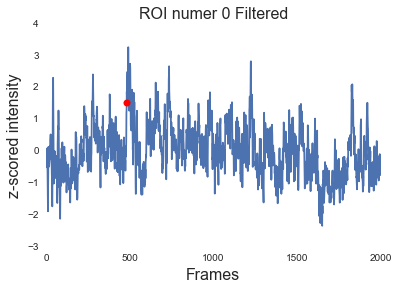

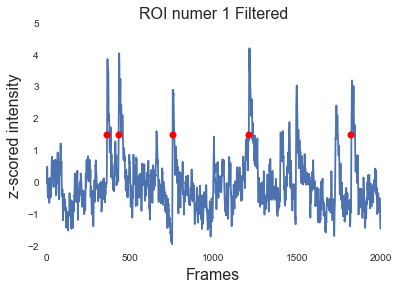

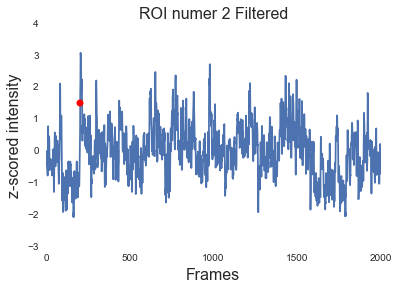

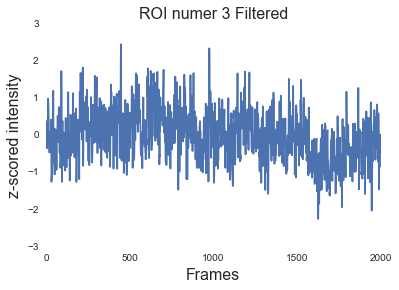

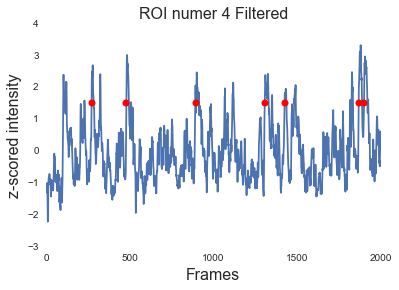

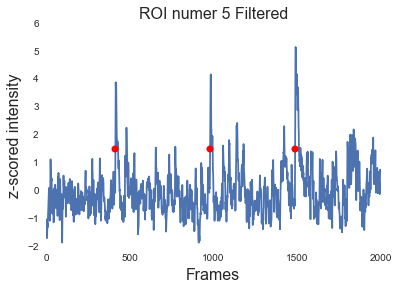

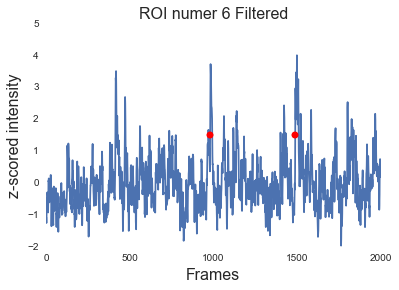

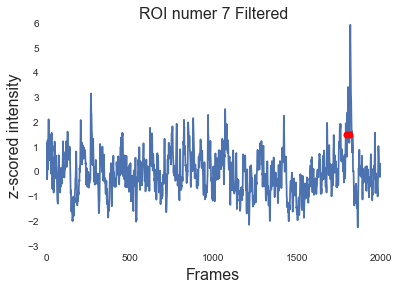

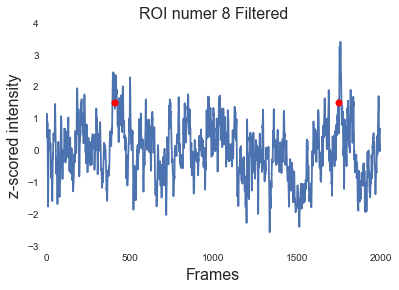

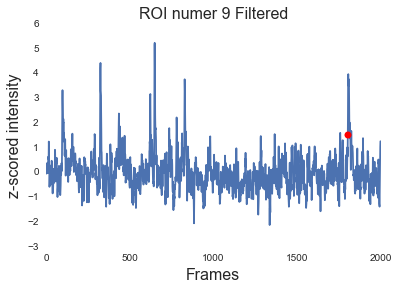

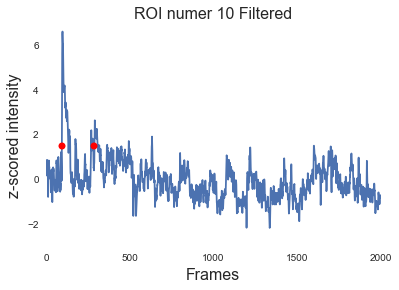

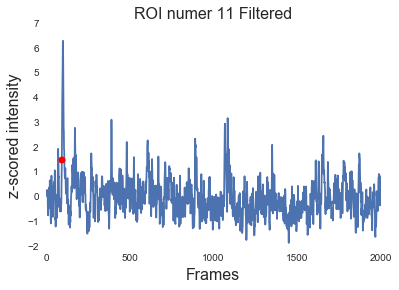

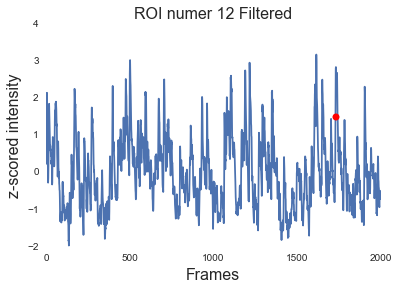

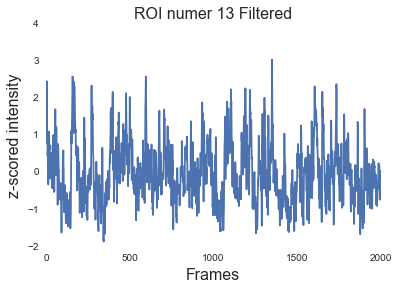

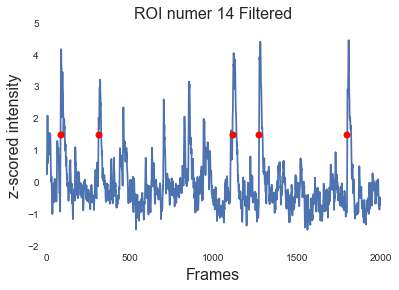

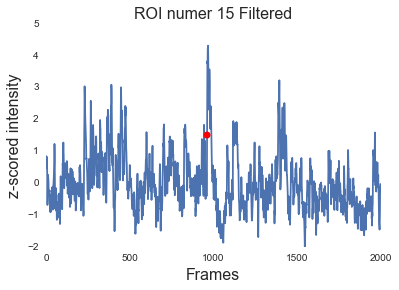

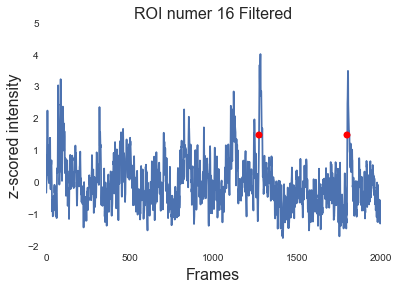

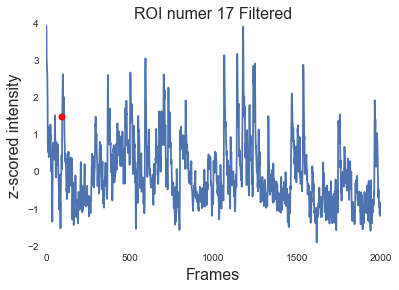

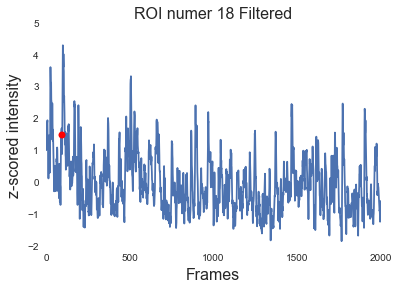

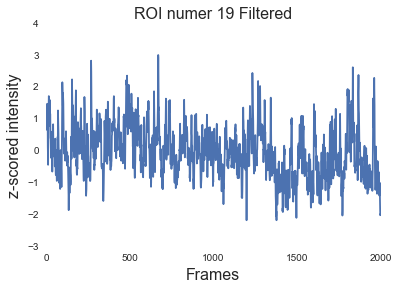

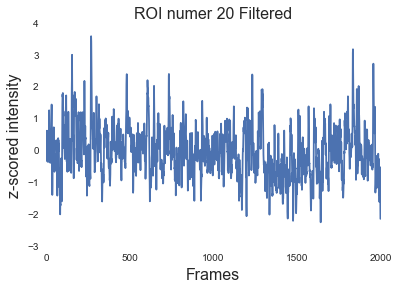

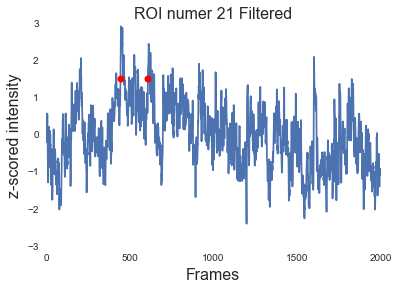

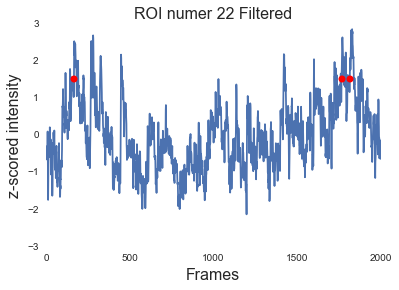

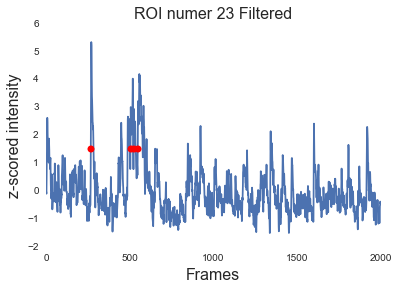

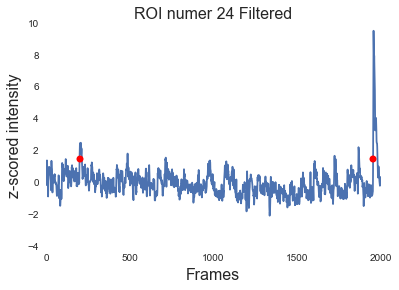

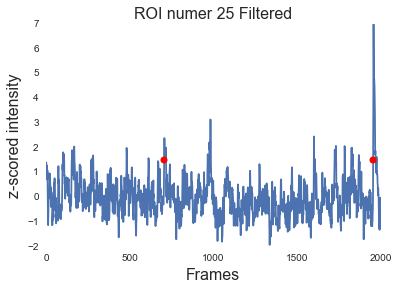

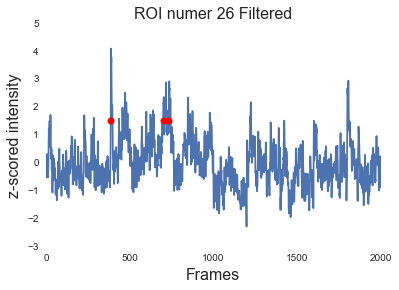

KeyboardInterrupt: 

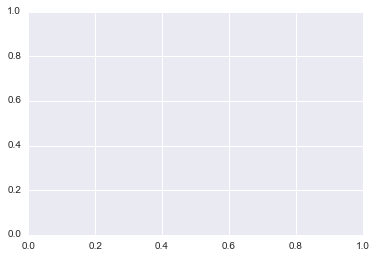

In [78]:
#plot ts with filtered event borders overlayed in red and export if desired
if plot_traces_filtered[0]=='yes':
    for a in range(0,numrois):
        fig,ax = plt.subplots(1)
        sns.tsplot(signals_smoothed[a,start_frame:end_frame])
        sns.tsplot(plot_events_filt[a,start_frame:end_frame], c='r', interpolate=False)
        plt.xlabel('Frames', fontsize='16')
        plt.ylabel(y_axis, fontsize='16')
        plt.title('ROI numer '+str(a)+' Filtered', fontsize='16')
        ax.set_axis_bgcolor('white')
        plt.show()
        if export_traces[0]=='yes':
            fig.savefig(filename+'_ROI_FILT'+str(a)+'.png', format='png')
            fig.clf()

In [ ]:
## load mask and filter data by mask
if load_mask[0]=='yes':
    def mask_events(data):
        data2=data[0:-1,:]
        for a in range(0,maskfile.shape[0]):
            if maskfile[a,0]==1:
                data2[a,:]=np.nan
        return data2
    peak_amp_MASK_filt=mask_events(peak_filt)
    auc_MASK_filt=mask_events(auc_durfilt)
    iei_MASK_filt=mask_events(iei_durfilt)
    event_frames_MASK_filt=mask_events(event_frames_durfilt)
    dur_MASK_filt=mask_events(allevents)

    peak_amp_MASK_filt_avg=np.nanmean(peak_amp_MASK_filt,axis=1)
    auc_MASK_filt_avg=np.nanmean(auc_MASK_filt,axis=1)
    iei_MASK_filt_avg=np.nanmean(iei_MASK_filt,axis=1)
    dur_MASK_filt_avg=np.nanmean(dur_MASK_filt,axis=1)

    if export_files[0]=='yes':
        np.savetxt(filename+'_Amp_MASK_filt_AVG.csv',peak_amp_MASK_filt_avg,delimiter=',')
        np.save(filename+'_peak_amp_MASK_filt', peak_amp_MASK_filt)
        np.save(filename+'_auc_MASK_filt', auc_MASK_filt)
        np.savetxt(filename+'_auc_MASK_filt_AVG.csv',auc_MASK_filt_avg,delimiter=',')
        np.save(filename+'_iei_MASK_filt',iei_MASK_filt)
        np.savetxt(filename+'_iei_MASK_filt_Avg.csv',iei_MASK_filt_avg,delimiter=',')
        np.save(filename+'_dur_MASK_filt',dur_MASK_filt)
        np.savetxt(filename+'_dur_MASK_filt_Avg.csv',dur_MASK_filt_avg,delimiter=',')
        np.save(filename+'_event_frames_MASK_filt',dur_MASK_filt)

In [ ]:
## filter data by event rate
if event_rate_filter_on[0]=='yes':
    test=np.nan*np.zeros((plot_events_filt.shape[0]))
    peak_amp_event_count_filt=peak_filt
    auc_event_count_filt=auc_durfilt
    iei_event_count_filt=iei_durfilt
    event_frames_event_count_filt=event_frames_durfilt
    dur_event_count_filt=allevents
    
    #eliminate cells that are below the min event threshold
    for a in range(0,plot_events_filt.shape[0]):
        if np.nansum(plot_events_filt[a,:])<=min_event_count:
            peak_amp_event_count_filt[a,:]=np.nan
            auc_event_count_filt[a,:]=np.nan
            iei_event_count_filt[a,:]=np.nan
            event_frames_event_count_filt[a,:]=np.nan
            dur_event_count_filt[a,:]=np.nan
        # eliminate cells that have 'drift' defined by difference between event rate in first 1/3 vs. last 1/3 of frames
        elif np.absolute((np.nansum(plot_events_filt[a,0:numframes/3]))-(np.nansum(plot_events_filt[a,numframes/3*2:numframes])))>max_difference:
            peak_amp_event_count_filt[a,:]=np.nan
            auc_event_count_filt[a,:]=np.nan
            iei_event_count_filt[a,:]=np.nan
            event_frames_event_count_filt[a,:]=np.nan
            dur_event_count_filt[a,:]=np.nan 
    peak_amp_event_count_filt_avg=np.nanmean(peak_amp_event_count_filt,axis=1)
    auc_event_count_filt_avg=np.nanmean(auc_event_count_filt,axis=1)
    iei_event_count_filt_avg=np.nanmean(iei_event_count_filt,axis=1) 
    dur_event_count_filt_avg=np.nanmean(dur_event_count_filt,axis=1)  
    
    #create mask for which cells to eliminate (cells to remove will be 1s and cells to keep will be nans)
    event_count_mask=np.ones((allevents.shape))
    for a in range(0,plot_events_filt.shape[0]):
        if np.nansum(peak_amp_event_count_filt[a])>0:
            event_count_mask[a,:]=np.nan
    event_count_mask=event_count_mask[0:-1,:]
    
    print 'Cells excluded = '+str(np.nansum(event_count_mask[:,0]))

    if export_files[0]=='yes':
        np.save(filename+'_peak_amp_EvntCT_filt', peak_amp_event_count_filt)
        np.savetxt(filename+'_Amp_EvntCT_filt_AVG.csv',peak_amp_event_count_filt_avg,delimiter=',')
        np.save(filename+'_auc_EvntCT_filt', auc_event_count_filt)
        np.savetxt(filename+'_auc_EvntCT_filt_AVG.csv',auc_event_count_filt_avg,delimiter=',')
        np.save(filename+'_iei_EvntCT_filt',iei_event_count_filt)
        np.savetxt(filename+'_iei_EvntCT_filt_Avg.csv',iei_event_count_filt_avg,delimiter=',')
        np.save(filename+'_dur_EvntCT_filt',dur_event_count_filt)
        np.savetxt(filename+'_dur_EvntCT_filt_Avg.csv',dur_event_count_filt_avg,delimiter=',')
        np.save(filename+'_event_frames_EventCT_filt',event_frames_event_count_filt)
        np.save(filename+'_event_count_MASK',event_count_mask)

In [ ]:
#display descriptive stats of durations
describe_durations=pd.DataFrame(allevents2)
pd.DataFrame.describe(describe_durations)

In [ ]:
#display descriptive stats of FILTERED durations
describe_durations_filt=pd.DataFrame(allevents_filt)
pd.DataFrame.describe(describe_durations_filt)

In [251]:
#display descriptive stats of areas
describe_areas=pd.DataFrame(allareas2)
pd.DataFrame.describe(describe_areas)

,0
count,1233.000000
mean,12.202114
std,33.232606
min,0.000000
25%,0.000000
50%,2.153050
75%,9.482815
max,510.792493


In [252]:
#display descriptive stats of FILTERED durations
describe_areas_filt=pd.DataFrame(allareas_filt)
pd.DataFrame.describe(describe_areas_filt)

,0
count,1233.000000
mean,12.202114
std,33.232606
min,0.000000
25%,0.000000
50%,2.153050
75%,9.482815
max,510.792493
